In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import aostools.climate as aos
import seaborn as sns
import numpy as np

In [2]:
## Pull in large dataset and manipulate to smaller one

# ds = xr.open_dataset('/disca/share/sit204/jra_55/1958_2016/atmos_daily_uvtw.nc')

# # rename variables
# rename_variables = {'var33': 'u',
#                     'var34': 'v',
#                     'var11': 't',
#                     'var39': 'omega'}

# ds = ds.rename(rename_variables)

# # extract DJF months from dataset
# import datetime as dt

# # ds = ds.where(ds.time.dt.month.isin([12, 1, 2]))
# ds = ds.sel(time=ds.time.dt.month.isin([12, 1, 2]))
# ds.to_netcdf('jra55_djf.nc')

In [3]:
# Import new, smaller dataset
ds = xr.open_dataset('/home/links/ct715/reanalysis_data/eddy_feedback/daily_datasets/datasets/JRA55_DJF/jra55_djf.nc')

# manipulate ds further
ds = ds.drop_dims('bnds')
ds.attrs = {}
ds['lev'] = ds.lev.values / 100
ds['lev_2'] = ds.lev_2.values / 100

# compute zonal mean zonal wind
ubar = ds.u.mean(('time','lon'))
ds

<xarray.Dataset>
Dimensions:  (time: 5325, lon: 144, lat: 73, lev: 37, lev_2: 37)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 7.0 5.0 3.0 2.0 1.0
  * lev_2    (lev_2) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u        (time, lev, lat, lon) float32 1.526 1.663 1.804 ... -1.786 -1.833
    v        (time, lev_2, lat, lon) float32 ...
    t        (time, lev_2, lat, lon) float32 ...
    omega    (time, lev_2, lat, lon) float32 ...

### Need to change dimension on zonal wind

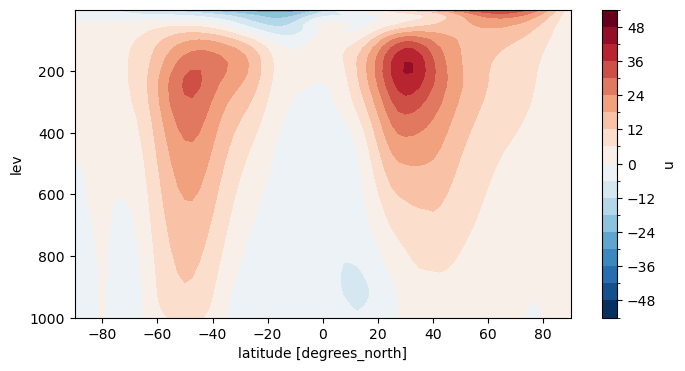

In [4]:
ubar.plot.contourf(levels=20, yincrease=False, yscale='linear', figsize=(8,4))

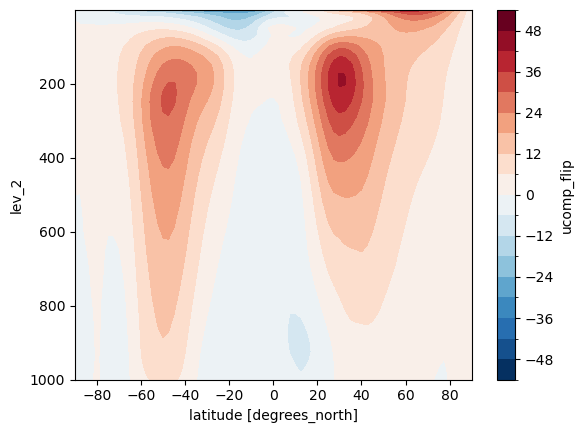

In [5]:
# check dims are definitely same but flipped
# ds.lev[::-1].values - ds.lev_2.values

ds['ucomp_flip'] = (ds['v'].dims, ds['u'][:,::-1,:,:].values)

ds['ucomp_flip'].mean(('time', 'lon')).plot.contourf(levels=20, yincrease=False)

In [6]:
# # FAILED ATTEMPT: creating new variable
# ds['ucomp'] = (ds.v.dims, ds.u.values)
# ucomp_bar = ds.ucomp.mean(('time','lon'))
# ucomp_bar.plot.contourf(levels=20, figsize=(8,4), yincrease=False, yscale='linear')

In [7]:
# # FAILED ATTEMPT: creating new variable and flip the values
# ds['ucomp'] = (ds.v.dims, np.flip(ds.u.values))
# ucomp_flip = ds.ucomp.mean(('time','lon'))
# ucomp_flip.plot.contourf(levels=20, figsize=(8,4), yincrease=False, yscale='linear')


In [8]:
# FAILED ATTEMPT: Just rename lev to lev_2 
# ds = ds.rename({'lev': 'lev_2'})

# # FAILED ATTEMPT: creating new variable and flip the values
# ds['ucomp'] = (ds.v.dims, np.flip(ds.u.values))
# ds['lat'] = np.flip(ds.lat)
# ucomp_flip = ds.ucomp.mean(('time','lon'))
# ucomp_flip.plot.contourf(levels=20, figsize=(8,4), yincrease=False, yscale='linear') 

## Plot EP Flux

In [9]:
# Solve EP flux
ep1, ep2, div1, div2 = aos.ComputeEPfluxDivXr(ds.ucomp_flip, ds.v, ds.t, 
                                              lon='lon', lat='lat', pres='lev_2', time='time', do_ubar=True)

ds['ep1'] = (ep1.dims, ep1.values)
ds['ep2'] = (ep2.dims, ep2.values)
ds['div1'] = (div1.dims, div1.values)
ds['div2'] = (div2.dims, div2.values)

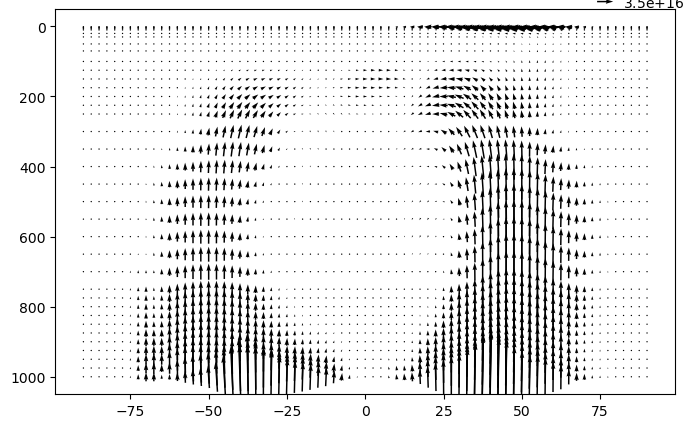

In [10]:
# define variables and skip some latitude
skip = dict(lat=slice(None, None, 1))

lat = ds.lat.isel(skip)
pressure = ds.lev_2
Fphi = ep1.mean(('time')).isel(skip)
Fp = ep2.mean(('time')).isel(skip)

# Plotting time
fig, ax = plt.subplots(figsize=(8,5))
aos.PlotEPfluxArrows(lat, pressure, Fphi, Fp,
                     fig, ax, pivot='mid')
# plt.savefig('JRA55daily_EPflux.png')
plt.show()

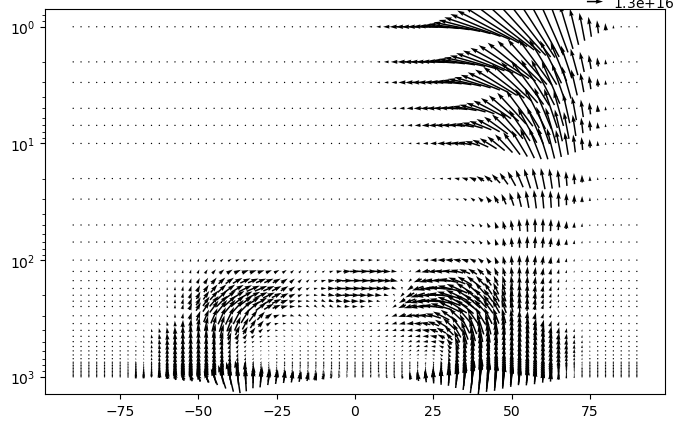

In [11]:
# define variables and skip some latitude
skip = dict(lat=slice(None, None, 1))

lat = ds.lat.isel(skip)
pressure = ds.lev_2
Fphi = ep1.mean(('time')).isel(skip)
Fp = ep2.mean(('time')).isel(skip)

# Plotting time
fig, ax = plt.subplots(figsize=(8,5))
aos.PlotEPfluxArrows(lat, pressure, Fphi, Fp,
                     fig, ax, pivot='mid', yscale='log')
# plt.savefig('JRA55daily_EPflux.png')
plt.show()

### Reproduce Nakamura Plot

In [12]:
# define some variables
ubar_flip = ds.ucomp_flip.mean(('time', 'lon'))

ds['ubar'] = (ubar_flip.dims, ubar_flip.values)
ds

<xarray.Dataset>
Dimensions:     (time: 5325, lon: 144, lat: 73, lev: 37, lev_2: 37)
Coordinates:
  * time        (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:0...
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat         (lat) float64 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lev         (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * lev_2       (lev_2) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u           (time, lev, lat, lon) float32 1.526 1.663 ... -1.786 -1.833
    v           (time, lev_2, lat, lon) float32 0.5638 3.017 ... -4.527 -4.621
    t           (time, lev_2, lat, lon) float32 ...
    omega       (time, lev_2, lat, lon) float32 ...
    ucomp_flip  (time, lev_2, lat, lon) float32 -56.05 -55.99 ... -2.199 -1.996
    ep1         (time, lev_2, lat) float64 0.005775 -9.301 ... 2.267 0.0006846
    ep2         (time, lev_2, lat) float64 -4.714e-12 -0.0002263 ... -0.0
    div1        (time, lev_2, lat) float64 -2.556e+12 8.165 ... 0.5561 3.03e+11
    div2        (time, lev_2, lat) float64 6.085e-07 4.714 ... -1.239 9.102e-07
    ubar        (lev_2, lat) float32 4.754e-06 6.469 11.92 ... -1.993 7.151e-06

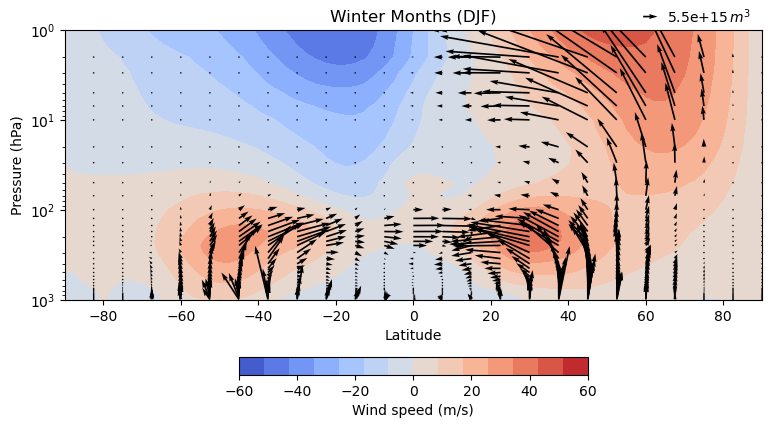

In [13]:
# import custom made function
import sys
sys.path.append('/home/links/ct715/reanalysis_data')
from aos.aos_functions import PlotEPfluxArrows

# skip both
skip_lat = 3
skip_pres = 1

skip = dict( lat=slice(None, None, skip_lat), lev_2=slice(None, None, skip_pres) )

x = ds.lat.isel(dict(lat=slice(None, None, skip_lat)))
y = ds.lev_2.isel(dict(lev_2=slice(None, None, skip_pres)))
u = ds.ep1.mean(('time')).isel(skip)
v = ds.ep2.mean(('time')).isel(skip)

coolwarm = sns.color_palette("coolwarm", as_cmap=True)

# start figure
fig, ax = plt.subplots(figsize=(9,5))

# plot colour map
plt.contourf(ds.lat.values, ds.lev_2.values, ubar_flip, 
             cmap=coolwarm, levels=np.linspace(-60,60,15))
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.5, 
             ticks=np.arange(-60,70,20), label='Wind speed (m/s)')

# Figure settings
plt.yscale('log')
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')
plt.title('Winter Months (DJF)')


# plot EP flux
PlotEPfluxArrows(x, y, u, v,
                fig, ax, pivot='tail', yscale='log')

plt.show()

In [14]:
ds = ds.drop_vars('u')
ds = ds.drop_dims('lev')

rename_variables = {'lev_2': 'level', 'ucomp_flip': 'u'}
ds = ds.rename(rename_variables)
ds

<xarray.Dataset>
Dimensions:  (time: 5325, lon: 144, lat: 73, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01T09:00:00 ... 2016-12-31T09:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    v        (time, level, lat, lon) float32 0.5638 3.017 ... -4.527 -4.621
    t        (time, level, lat, lon) float32 ...
    omega    (time, level, lat, lon) float32 ...
    u        (time, level, lat, lon) float32 -56.05 -55.99 ... -2.199 -1.996
    ep1      (time, level, lat) float64 0.005775 -9.301 ... 2.267 0.0006846
    ep2      (time, level, lat) float64 -4.714e-12 -0.0002263 ... -0.01356 -0.0
    div1     (time, level, lat) float64 -2.556e+12 8.165 ... 0.5561 3.03e+11
    div2     (time, level, lat) float64 6.085e-07 4.714 ... -1.239 9.102e-07
    ubar     (level, lat) float32 4.754e-06 6.469 11.92 ... -1.993 7.151e-06

In [16]:
ds.to_netcdf('/home/links/ct715/reanalysis_data/eddy_feedback/daily_datasets/jra55_djb_ep.nc')


### Pseudoheight

In [ ]:
# Define constants
Rd = 287.04             # [J/kg/K]
g = 9.81                # [m/s^2]
T0 = 270                # [K]
p0 = 1e3                # [hPa]

# pull variable
pres = ds.lev_2

# Define the constant scale height H0
H0 = (Rd*T0) / g 

# Isothermal pseudoheight
Zlog = -H0 * np.log(pres/p0)
ds['Zlog'] = Zlog / 1000
ds.Zlog

In [ ]:
# plot isothmeral pseudoheight
fig, ax = plt.subplots(figsize=(9,5))
plt.contourf(ds.lat.values, ds.Zlog.values, ubar_flip, 
             cmap=coolwarm, levels=np.linspace(-60,60,15))
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.5, 
             ticks=np.arange(-60,70,20), label='Wind speed (m/s)')
plt.title('Zonal-mean zonal wind plot for winter months (DJF)')
plt.xlabel('Latitude [$^\\circ$N]')
plt.ylabel('Pseudoheight [$km$]')
plt.show()

In [ ]:
# skip latitude
skip_lat = 2
skip = dict( lat=slice(None, None, skip_lat) )

x = ds.lat.isel(skip)
y = ds.Zlog
u = ds.ep1.mean(('time')).isel(skip)
v = ds.ep2.mean(('time')).isel(skip)

coolwarm = sns.color_palette("coolwarm", as_cmap=True)

# start figure
fig, ax = plt.subplots(figsize=(8,5))

# plot colour map
plt.contourf(ds.lat.values, ds.Zlog.values, ubar_flip, 
             cmap=coolwarm, levels=np.linspace(-60,60,15))
plt.colorbar(location='bottom', orientation='horizontal', shrink=0.5, 
             ticks=np.arange(-60,70,20), label='Wind speed (m/s)')

# Figure settings
ax.invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Pseudoheight [km]')


# plot EP flux
aos.PlotEPfluxArrows(x, y, u, v,
                     fig, ax, pivot='mid')

plt.show()